In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import random
import tensorflow as tf
from sklearn.feature_extraction import image
#import pickle
from pathlib import Path
import matplotlib.pyplot as plt


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
#functions
#converts rgb to gray values
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [7]:
#bookkeeping
gh = []          ##holds the input images, each element is a list of images of a given type.
l = []           ##output labels 1 = bad, 0 = good.
label = []       ##holds label names from folders of training images.
#k = []

la = []          ##labels for training 
train_image = [] ##training images, which includes patchs
train_patch = [] ##contains array whose elements are arrays of patches for each training image.

#f = []

In [10]:
#get data path and condense labels from 4 categories to just 2
trainData = False
testData = !trainData

if(trainData):
    pa = Path("C:/Users/Justin'sPC/Desktop/brehis/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/Photos")
if(testData):
    pa = Path("C:/Users/Justin'sPC/Desktop/brehis/ICIAR2018_BACH_Challenge/ICIAR2018_BACH_Challenge/test")
    
os.chdir(pa)
labels = [name for name in os.listdir(".") if os.path.isdir(name)]
filename = [os.path.join(pa,name) for name in labels if os.path.isdir(os.path.join(pa,name))]

for name in labels:
    if name == 'Invasive':
        d = 1
    if name == 'Normal':
        d = 0
    if name == 'InSitu':
        d = 1
    if name == 'Benign':
        d = 0
    l.append(d)


In [11]:
#actually get the images
for i in filename:
    test = []
    for im in os.listdir(i): 
        if not im.startswith('.'):

            images = io.imread(os.path.join(i,im))
            images = images.astype(np.uint8)
            #images = rgb2gray(images)
            #images = np.expand_dims(images, axis=2)
            imarray = np.array(images)
            test.append(images)
    gh.append(test)

print(l)
print(len(gh))
#print [name for name in os.listdir(".") if os.path.isdir(name)]
#print images
print(len(gh[0]))
print(len(gh[1]))
print(len(gh[2]))
print(len(gh[3]))

[0, 1, 1, 0, 0, 1, 1, 0]
8
20
20
20
20


In [12]:
##merge the 4 types of images together into 1 set and do same for their labels (l) into label
merge = gh[0] + gh[1] + gh[2] + gh[3]
label = []  ##reinit here so if we run this cell over and over it doesn't just keep adding.
print(len(merge))
print(len(merge))
for i in range(len(gh)):
    for j in range(len(gh[i])):
        n = l[i]
        label.append(n)
print(len(label))
print(merge[0].shape)

80
80
160
(1536, 2048, 3)


In [13]:
##get ready to tensorflow
ksize_rows = 256
ksize_cols = 256
strides_rows = 256
strides_cols = 256
Lin = len(merge)

[     1      6      8 196608]
[ 48 256 256   3]


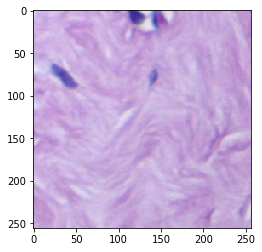

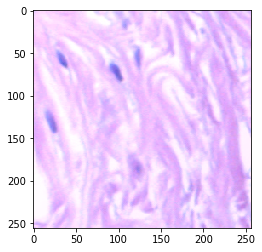

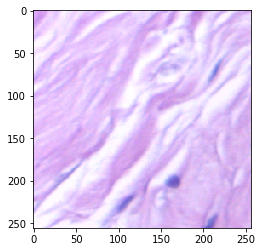

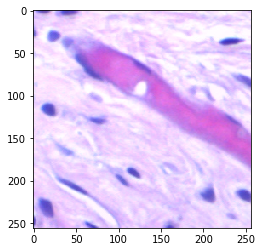

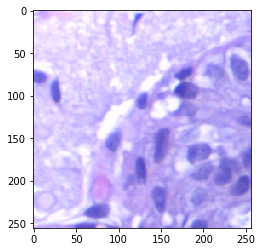

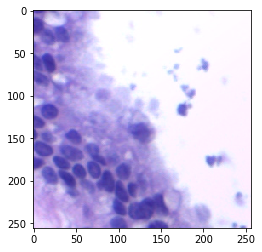

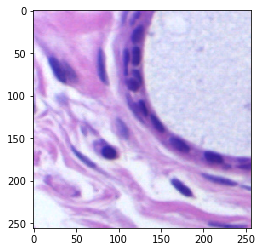

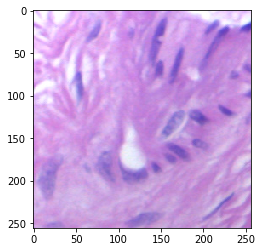

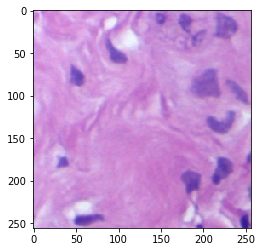

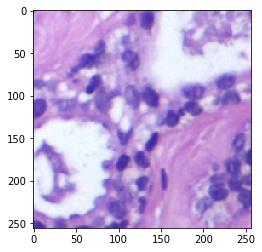

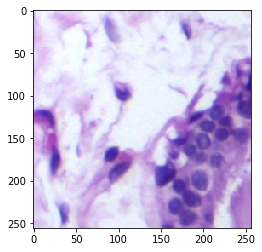

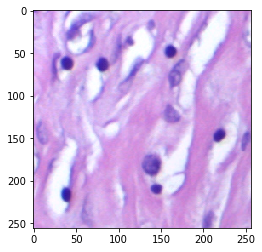

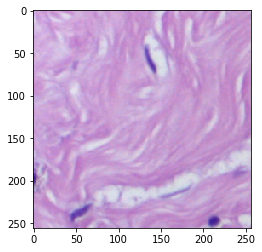

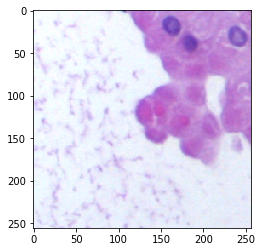

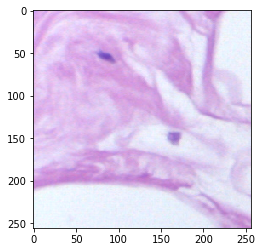

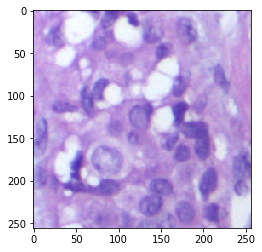

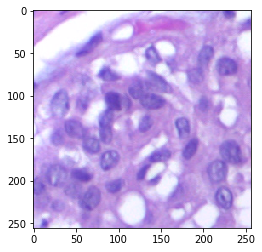

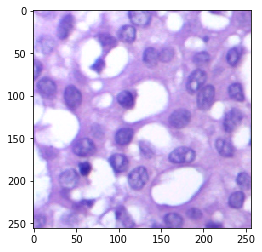

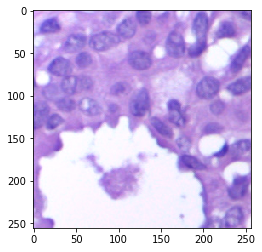

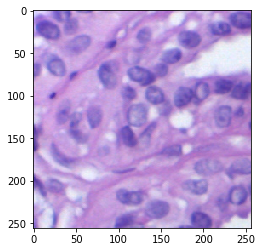

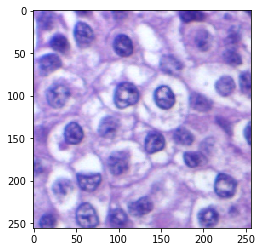

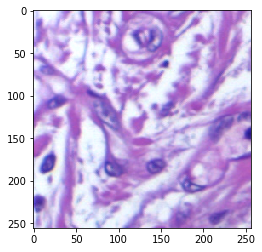

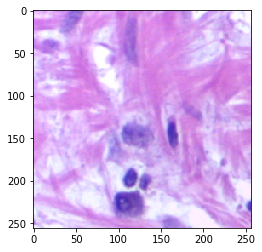

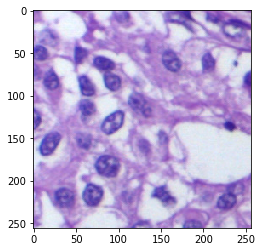

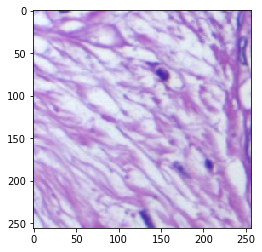

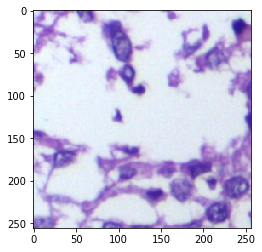

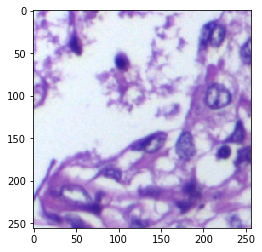

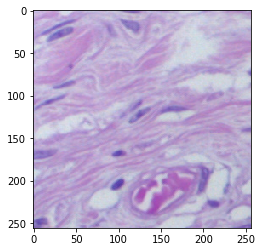

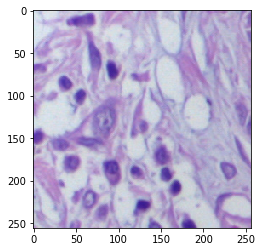

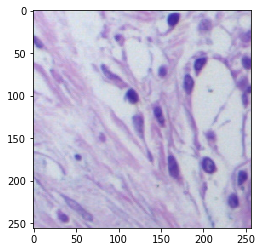

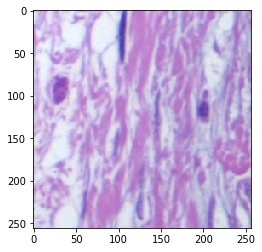

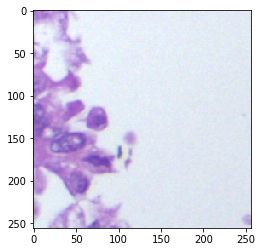

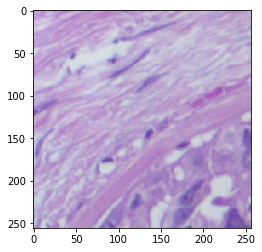

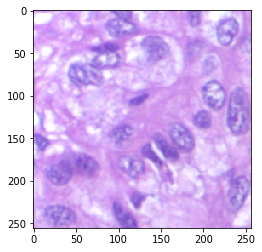

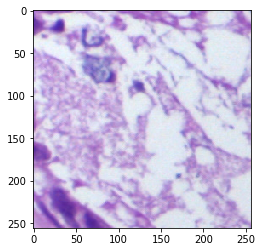

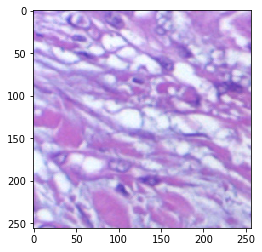

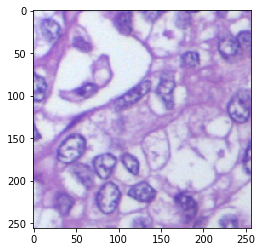

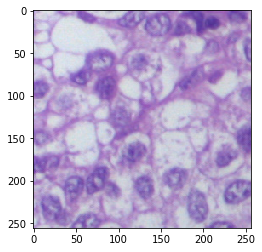

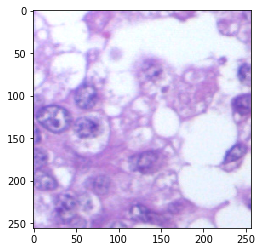

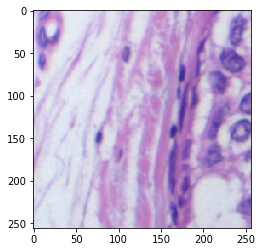

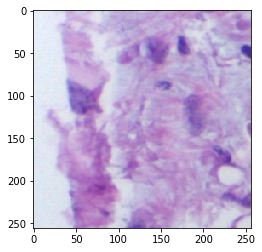

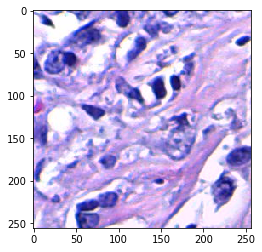

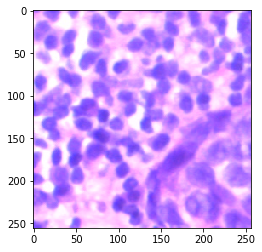

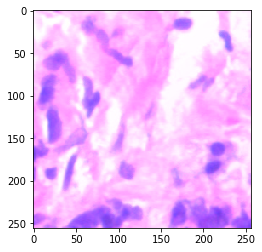

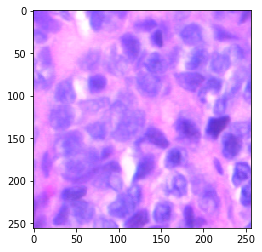

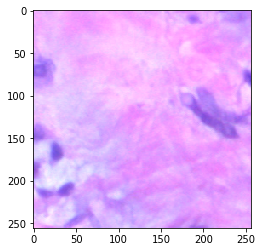

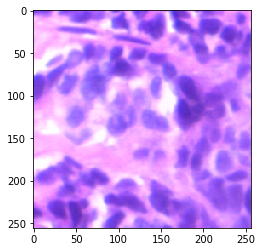

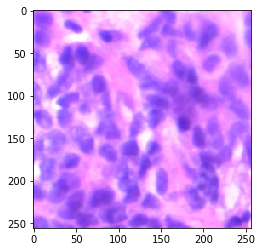

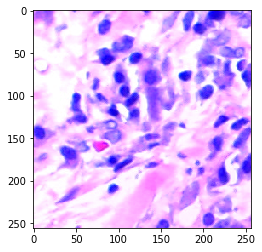

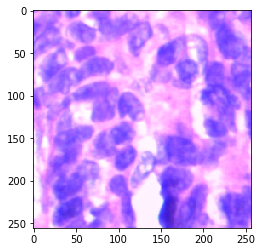

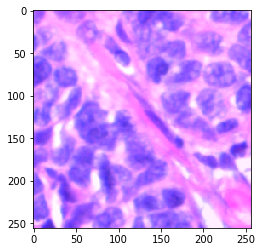

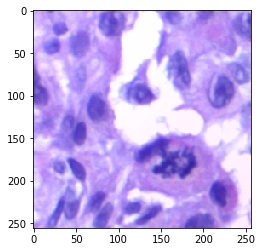

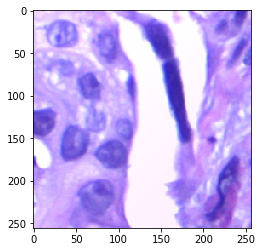

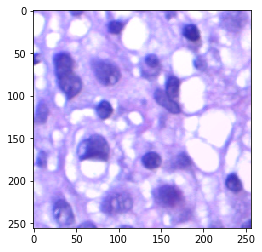

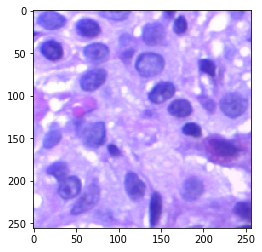

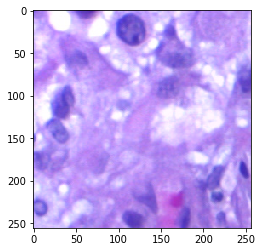

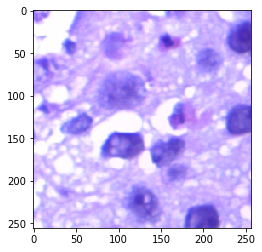

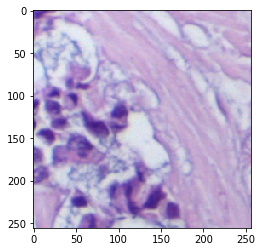

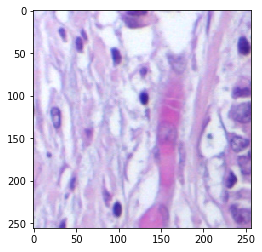

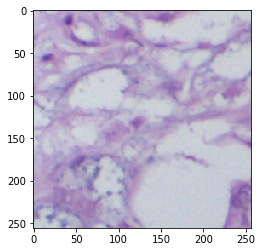

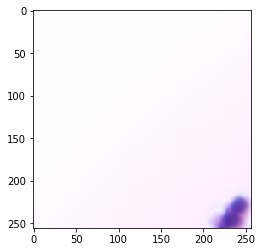

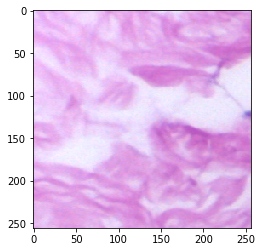

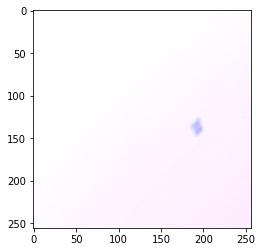

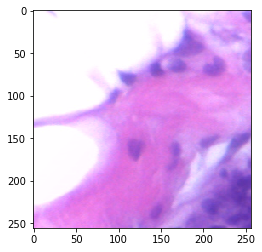

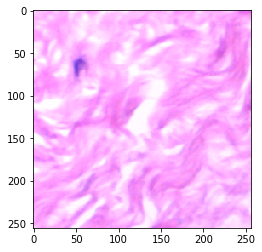

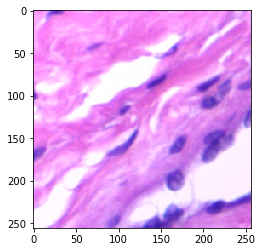

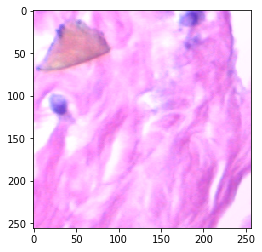

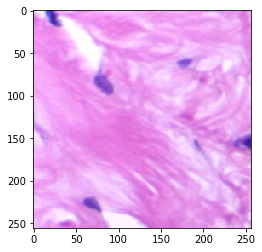

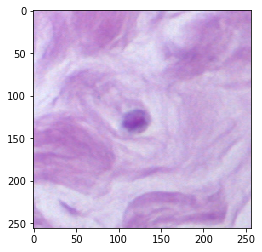

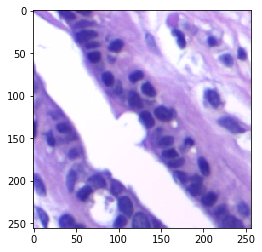

In [ ]:
sess = tf.InteractiveSession()
for i in range(len(merge)):

    image = merge[i]

    # The size of sliding window
    ksizes = [1, ksize_rows, ksize_cols, 1] 

    # How far the centers of 2 consecutive patches are in the image
    strides = [1, strides_rows, strides_cols, 1]

    # The document is unclear. However, an intuitive example posted on StackOverflow illustrate its behaviour clearly. 
    # http://stackoverflow.com/questions/40731433/understanding-tf-extract-image-patches-for-extracting-patches-from-an-image
    rates = [1, 1, 1, 1] # sample pixel consecutively

    # padding algorithm to used
    padding='VALID' # or 'SAME'

    image = tf.expand_dims(image, 0)
    image_patches = tf.extract_image_patches(image, ksizes, strides, rates, padding)
    if i == 0:
                print(sess.run(tf.shape(image_patches)))

    # print image shape of image patches
    #print sess.run(tf.shape(image_patches))

    # image_patches is 4 dimension array, you can use tf.squeeze to squeeze it, e.g.
    # image_patches = tf.squeeze(image_patches)

    # retrieve the 1st patches
    patch1 = image_patches[0,0,0,]
    patch2 = image_patches[0,0,1,]

    # reshape
    patch1 = tf.reshape(patch1, [ksize_rows, ksize_cols, 3])
    patches = tf.reshape(image_patches, [48,ksize_rows, ksize_cols, 3])
    train_patch.append(sess.run(patches))
    if i == 0:
                print(sess.run(tf.shape(patches)))
    # visualize image
    import matplotlib.pyplot as plt
    plt.imshow(sess.run(patch1))
    plt.show()
sess.close()
print("Done")

In [19]:
##coalesce the patches
print(len(train_patch))
for i in range(len(train_patch)):
        #if label[i] == 1:
        ##48 is len(train_patch[0], that is all patches of image)
        for j in range(48):
                im = np.squeeze(train_patch[i][j,...])
                #im = np.expand_dims(im, axis=2)
                #im = np.float32(im)
                d = label[i]
                la.append(d)
                train_image.append(im)
print(len(train_image))
print(train_image[0].dtype)
print(len(la))
print(la[0])

80
3840
uint8
3840
0


In [20]:
s = list(range(len(train_image)))
random.shuffle(s)
if(trainData):
    test_filename = 'breahist_train.tfrecords'
if(testData):
    test_filename = 'breahist_test.tfrecords'
writer = tf.python_io.TFRecordWriter(test_filename)

In [21]:
for i in s:
    image_raw =  train_image[i].tostring()
 #   im = test_image[i]
    height = train_image[i].shape[0]
    width = train_image[i].shape[1]
    features = {'test/image': _bytes_feature(image_raw),
               'test/label': _int64_feature(la[i]),
               'test/height': _int64_feature(height),
               'test/width': _int64_feature(width)}
    examples = tf.train.Example(features = tf.train.Features(feature = features))
    writer.write(examples.SerializeToString())

writer.close()

print(merge[0].shape)

(1536, 2048, 3)
